In [13]:
import os
import patchconvnet_models as patch
import patchconvnet_models_ablation as patch_abl
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import optuna



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 128
num_epochs = 16
num_classes = 100
lr = 1e-4
num_workers = 4

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,num_workers=num_workers, pin_memory=True)




Files already downloaded and verified
Files already downloaded and verified


In [29]:
class PatchConvNetGMP(nn.Module):
    def __init__(self, num_classes=100, pretrained=False,drop_path_rate=0.0001):
        super().__init__()

        # Zamiana oryginalnego klasyfikatora na GAP + Linear
        self.model = patch_abl.S60(pretrained=pretrained, num_classes=num_classes,drop_path_rate=drop_path_rate)
        self.model.head = nn.Identity()  # wyłączenie oryginalnej głowy
        self.pooling = nn.Linear(self.model.embed_dim, num_classes)
        

    def forward(self, x):
        x = self.model.forward_features(x)
        # print("x after forward_features:", x.shape)
        x = torch.max(x,dim=1).values
        # print("x after GMP:", x.shape)
        return self.pooling(x)

In [30]:
class PatchConvNetGAP(nn.Module):
    def __init__(self, num_classes=100, pretrained=False,drop_path_rate=0.0001):
        super().__init__()

        # Zamiana oryginalnego klasyfikatora na GAP + Linear
        self.model = patch_abl.S60(pretrained=pretrained, num_classes=num_classes,drop_path_rate=drop_path_rate)
        self.model.head = nn.Identity()  # wyłączenie oryginalnej głowy
        self.pooling = nn.Linear(self.model.embed_dim, num_classes)
        

    def forward(self, x):
        x = self.model.forward_features(x)
        # print("x after forward_features:", x.shape)
        x = x.mean(dim=1)

        # print("x after GMP:", x.shape)
        return self.pooling(x)

In [18]:
def train(model, train_loader, epochs=10,lr=1e-3,weight_decay=0.01):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr,weight_decay=weight_decay)
    train_loss = []
    for epoch in range(epochs):
        epoch_loss = 0.0
        model.train()
        for inputs, targets in tqdm(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            epoch_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        epoch_loss/batch_size
        train_loss.append(epoch_loss)
    plt.plot([x for x in range(epoch+1)],train_loss)
    plt.xlabel("num_epochs")
    plt.ylabel("Loss")
    plt.title("training_loss")
    plt.show()


In [19]:
def evaluate(model, dataloader):
    model.eval()
    top1_correct = 0
    top5_correct = 0
    total = 0

    with torch.no_grad():
        for x, y in tqdm(dataloader):
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            _, pred = outputs.topk(5, 1, True, True)
            total += y.size(0)
            top1_correct += (pred[:, 0] == y).sum().item()
            top5_correct += sum([y[i] in pred[i] for i in range(y.size(0))])

    return top1_correct / total, top5_correct / total

Dobór hyperparametrów

Oryginalny model


100%|██████████| 391/391 [00:49<00:00,  7.91it/s]


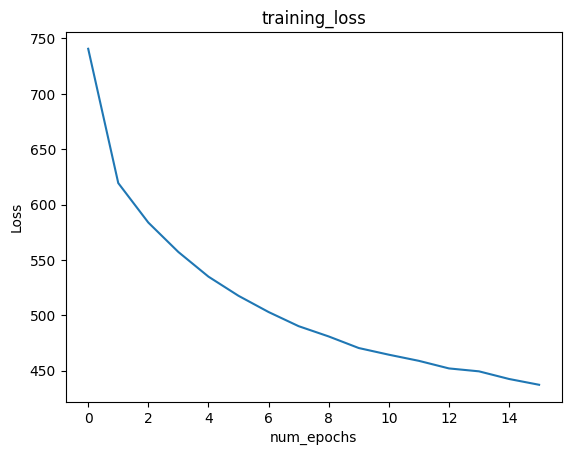

100%|██████████| 79/79 [00:13<00:00,  5.67it/s]


In [20]:
model_orig = patch.S60(num_classes=100, pretrained=False,drop_path_rate=0)
print("Oryginalny model")
train(model_orig, train_loader, epochs=num_epochs)
acc1_orig, acc5_orig = evaluate(model_orig,test_loader )

In [21]:
print(f"Oryginalny model  - Top1: {acc1_orig:.4f} | Top5: {acc5_orig:.4f}")

Oryginalny model  - Top1: 0.5785 | Top5: 0.9568


Oryginalny model


100%|██████████| 391/391 [03:14<00:00,  2.01it/s]


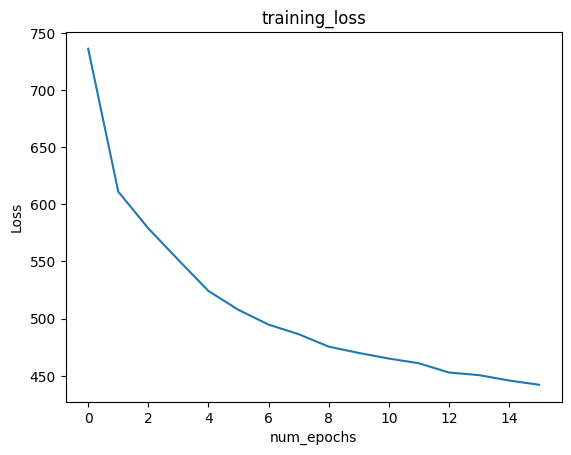

100%|██████████| 79/79 [00:13<00:00,  5.72it/s]


In [22]:
model_orig = patch.B60(num_classes=100, pretrained=False)
print("Oryginalny model")
train(model_orig, train_loader, epochs=num_epochs)
acc1_orig, acc5_orig = evaluate(model_orig,test_loader )

In [23]:
print(f"Oryginalny model  - Top1: {acc1_orig:.4f} | Top5: {acc5_orig:.4f}")

Oryginalny model  - Top1: 0.5666 | Top5: 0.9557


Oryginalny model


100%|██████████| 391/391 [13:44<00:00,  2.11s/it]


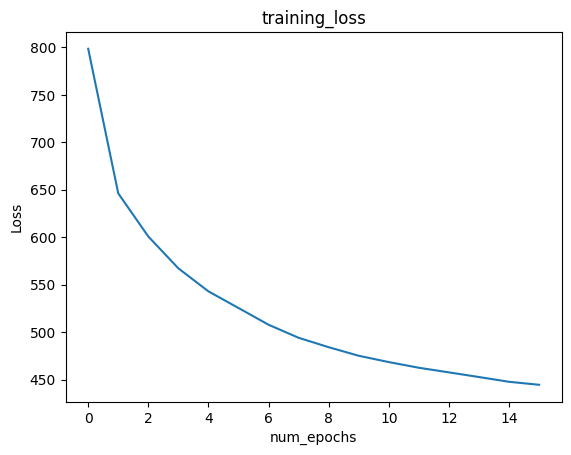

100%|██████████| 79/79 [00:14<00:00,  5.57it/s]


In [24]:
model_orig = patch.L60(num_classes=100, pretrained=False)
print("Oryginalny model")
train(model_orig, train_loader, epochs=num_epochs)
acc1_orig, acc5_orig = evaluate(model_orig, test_loader)

In [25]:
print(f"Oryginalny model  - Top1: {acc1_orig:.4f} | Top5: {acc5_orig:.4f}")

Oryginalny model  - Top1: 0.5647 | Top5: 0.9533


In [26]:

def objective(trial):
    # Propozycje hiperparametrów
    drop_path = trial.suggest_float("drop_path_rate", 0.0, 0.5)
    lr = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-6, 1e-2)

    model = patch.S60(drop_path_rate=drop_path)
    model.to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    # 1 epoka walidacyjna (dla szybkości — zwiększ wedle potrzeb)
    model.train()
    for epoch in range(num_epochs):
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Walidacja
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return 1.0 - accuracy  # ponieważ Optuna minimalizuje

# Uruchom tuning
study = optuna.create_study()
study.optimize(objective, n_trials=10)

print("Najlepsze parametry:", study.best_params)

[I 2025-05-15 06:44:48,569] A new study created in memory with name: no-name-ce21292d-bcc7-44c5-9cbb-d88566a220e5
C:\Users\stasi\AppData\Local\Temp\ipykernel_18032\1931665135.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
C:\Users\stasi\AppData\Local\Temp\ipykernel_18032\1931665135.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-6, 1e-2)
[I 2025-05-15 07:16:18,529] Trial 0 finished with value: 0.9 and parameters: {'drop_path_rate': 0.17100028576508908, 'learning_rate': 0.0024727175977162434, 'weight_decay': 0.004723143684000506}. Best is trial 0

Najlepsze parametry: {'drop_path_rate': 0.45190457388377236, 'learning_rate': 0.00043402904652030855, 'weight_decay': 1.1586491479663203e-05}



Wybrane parametry

In [27]:
study.best_params

{'drop_path_rate': 0.45190457388377236,
 'learning_rate': 0.00043402904652030855,
 'weight_decay': 1.1586491479663203e-05}

In [31]:
drop_path_rate = study.best_params["drop_path_rate"]
lr = study.best_params["learning_rate"]
weight_decay = study.best_params["weight_decay"]
num_epochs = 20

Test 1

Oryginalny model


100%|██████████| 391/391 [01:07<00:00,  5.82it/s]


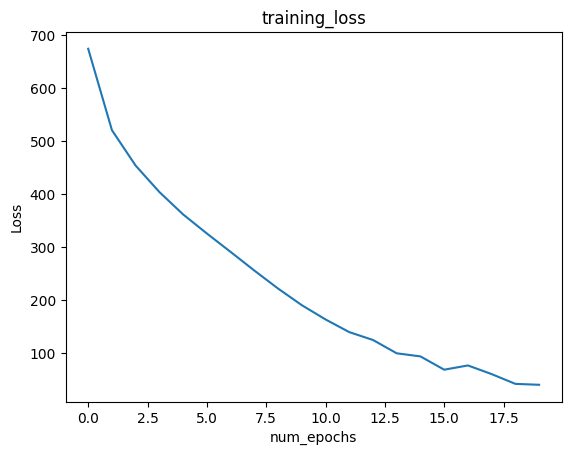

100%|██████████| 79/79 [00:15<00:00,  5.00it/s]


Bez atencji


100%|██████████| 391/391 [01:30<00:00,  4.30it/s]


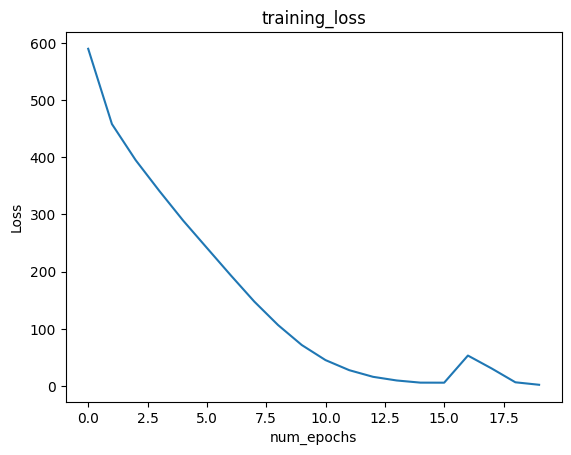

100%|██████████| 79/79 [00:15<00:00,  5.26it/s]


In [32]:
model_orig = patch.S60(num_classes=100, pretrained=False,drop_path_rate=drop_path_rate)
print("Oryginalny model")
train(model_orig, train_loader, epochs=20,lr=lr,weight_decay=weight_decay)
acc1_orig, acc5_orig = evaluate(model_orig, test_loader)

# Model z GAP
model_gap = PatchConvNetGMP(num_classes=100, pretrained=False,drop_path_rate=drop_path_rate)
print("Bez atencji")
train(model_gap, train_loader, epochs=20,lr=lr,weight_decay=weight_decay)
acc1_gap, acc5_gap = evaluate(model_gap, test_loader)

In [33]:
print("🔍 Porównanie:")
print(f"Oryginalny model  - Top1: {acc1_orig:.4f} | Top5: {acc5_orig:.4f}")
print(f"Model z GAP       - Top1: {acc1_gap:.4f} | Top5: {acc5_gap:.4f}")

🔍 Porównanie:
Oryginalny model  - Top1: 0.6504 | Top5: 0.9623
Model z GAP       - Top1: 0.6992 | Top5: 0.9732


Test 2 

Bez atencji


100%|██████████| 391/391 [01:47<00:00,  3.65it/s]


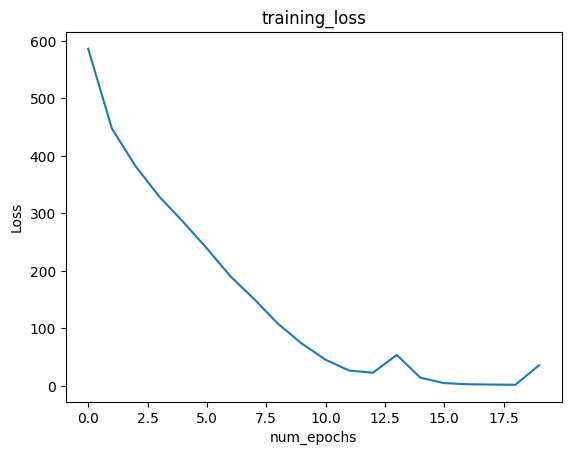

100%|██████████| 79/79 [00:17<00:00,  4.60it/s]


In [34]:
model_gap = PatchConvNetGMP(num_classes=100, pretrained=False,drop_path_rate=drop_path_rate)
print("Bez atencji")
train(model_gap, train_loader, epochs=20,lr=lr,weight_decay=weight_decay)
acc1_gap, acc5_gap = evaluate(model_gap, test_loader)

In [35]:
print("🔍 Porównanie:")
print(f"Oryginalny model  - Top1: {acc1_orig:.4f} | Top5: {acc5_orig:.4f}")
print(f"Model z GAP       - Top1: {acc1_gap:.4f} | Top5: {acc5_gap:.4f}")

🔍 Porównanie:
Oryginalny model  - Top1: 0.6504 | Top5: 0.9623
Model z GAP       - Top1: 0.6510 | Top5: 0.9598


Test 3

Bez atencji


100%|██████████| 391/391 [01:42<00:00,  3.80it/s]


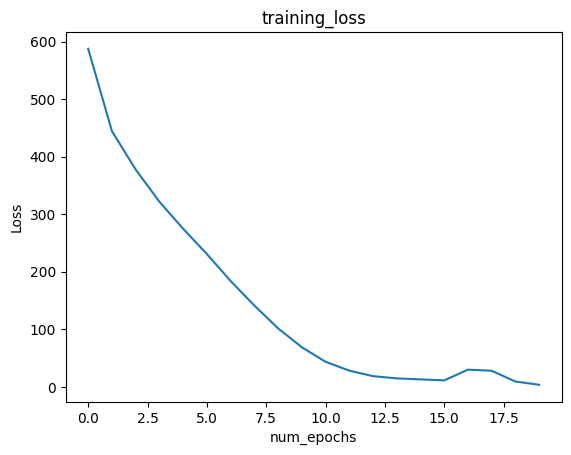

100%|██████████| 79/79 [00:16<00:00,  4.77it/s]


In [36]:
model_gap = PatchConvNetGMP(num_classes=100, pretrained=False,drop_path_rate=drop_path_rate)
print("Bez atencji")
train(model_gap, train_loader, epochs=20,lr=lr,weight_decay=weight_decay)
acc1_gap, acc5_gap = evaluate(model_gap, test_loader)

In [37]:
print("🔍 Porównanie:")
print(f"Oryginalny model  - Top1: {acc1_orig:.4f} | Top5: {acc5_orig:.4f}")
print(f"Model z GAP       - Top1: {acc1_gap:.4f} | Top5: {acc5_gap:.4f}")

🔍 Porównanie:
Oryginalny model  - Top1: 0.6504 | Top5: 0.9623
Model z GAP       - Top1: 0.6983 | Top5: 0.9739


TEST - GAP

Bez atencji


100%|██████████| 391/391 [01:35<00:00,  4.10it/s]


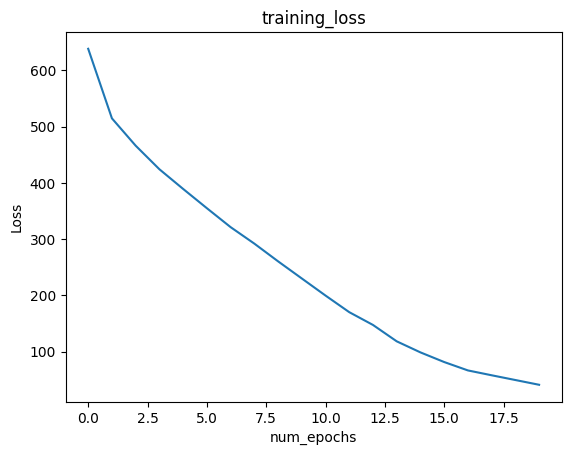

100%|██████████| 79/79 [00:16<00:00,  4.68it/s]


In [38]:

# Model z GAP
model_gap = PatchConvNetGAP(num_classes=100, pretrained=False,drop_path_rate=drop_path_rate)
print("Bez atencji")
train(model_gap, train_loader, epochs=20,lr=lr,weight_decay=weight_decay)
acc1_gap, acc5_gap = evaluate(model_gap, test_loader)

In [39]:
print("🔍 Porównanie:")
print(f"Oryginalny model  - Top1: {acc1_orig:.4f} | Top5: {acc5_orig:.4f}")
print(f"Model z GAP       - Top1: {acc1_gap:.4f} | Top5: {acc5_gap:.4f}")

🔍 Porównanie:
Oryginalny model  - Top1: 0.6504 | Top5: 0.9623
Model z GAP       - Top1: 0.6765 | Top5: 0.9703


Test 3

Bez atencji


100%|██████████| 391/391 [01:42<00:00,  3.82it/s]


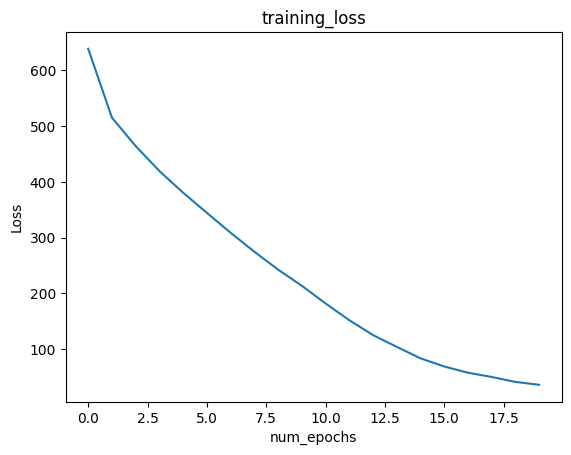

100%|██████████| 79/79 [00:17<00:00,  4.61it/s]


In [40]:
# Model z GAP
model_gap = PatchConvNetGAP(num_classes=100, pretrained=False,drop_path_rate=drop_path_rate)
print("Bez atencji")
train(model_gap, train_loader, epochs=20,lr=lr,weight_decay=weight_decay)
acc1_gap, acc5_gap = evaluate(model_gap, test_loader)

In [41]:
print("🔍 Porównanie:")
print(f"Oryginalny model  - Top1: {acc1_orig:.4f} | Top5: {acc5_orig:.4f}")
print(f"Model z GAP       - Top1: {acc1_gap:.4f} | Top5: {acc5_gap:.4f}")

🔍 Porównanie:
Oryginalny model  - Top1: 0.6504 | Top5: 0.9623
Model z GAP       - Top1: 0.6716 | Top5: 0.9636


Bez atencji


100%|██████████| 391/391 [01:26<00:00,  4.54it/s]


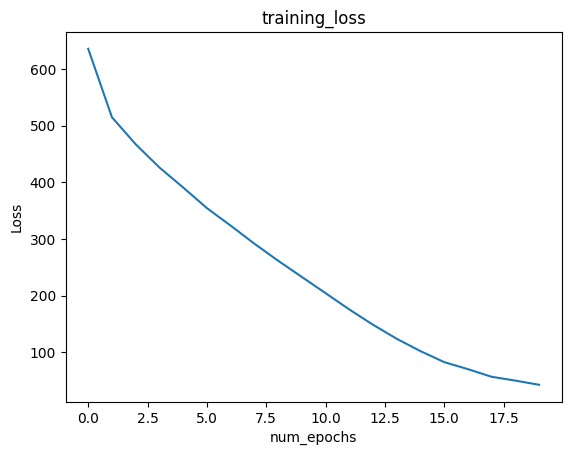

100%|██████████| 79/79 [00:14<00:00,  5.27it/s]


In [42]:
model_gap = PatchConvNetGAP(num_classes=100, pretrained=False,drop_path_rate=drop_path_rate)
print("Bez atencji")
train(model_gap, train_loader, epochs=20,lr=lr,weight_decay=weight_decay)
acc1_gap, acc5_gap = evaluate(model_gap, test_loader)

In [43]:
print("🔍 Porównanie:")
print(f"Oryginalny model  - Top1: {acc1_orig:.4f} | Top5: {acc5_orig:.4f}")
print(f"Model z GAP       - Top1: {acc1_gap:.4f} | Top5: {acc5_gap:.4f}")

🔍 Porównanie:
Oryginalny model  - Top1: 0.6504 | Top5: 0.9623
Model z GAP       - Top1: 0.6785 | Top5: 0.9700


In [47]:
class PatchConvNetAblation(nn.Module):
    def __init__(self,
                num_classes=1000,
                pretrained= False,
                use_relu = False,
                drop_path_rate = 0.0
                ):
        super(PatchConvNetAblation, self).__init__()
        
        self.model = patch.S60(pretrained=pretrained,num_classes=num_classes,drop_path_rate=drop_path_rate)
        if use_relu:
            self._replace_gelu_with_relu()
            
        in_features = self.model.get_classifier().in_features
        self.model.reset_classifier(num_classes=num_classes)
        
    def _replace_gelu_with_relu(self):
        def replace(module):
            for name, child in module.named_children():
                if isinstance(child,nn.GELU):
                    setattr(self.model,name,nn.ReLU())
                else:
                    replace(child)
        replace(self.model)
    def forward(self,x):
        return self.model(x)

Z RELU


100%|██████████| 391/391 [00:51<00:00,  7.52it/s]


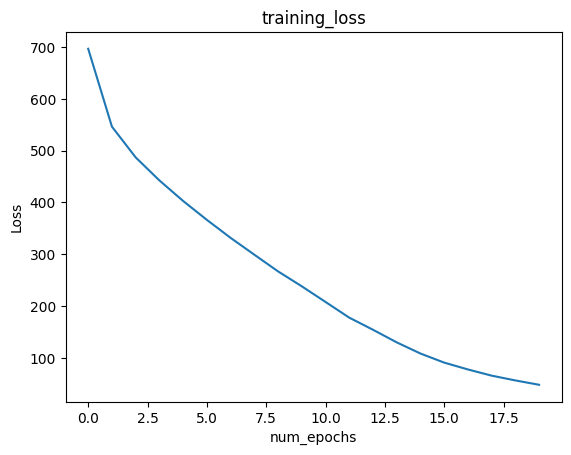

100%|██████████| 79/79 [00:14<00:00,  5.44it/s]


In [48]:
model_RELU = PatchConvNetAblation(num_classes=100, pretrained=False,drop_path_rate=drop_path_rate)
print("Z RELU")
train(model_RELU, train_loader, epochs=20,lr=lr,weight_decay=weight_decay)
acc1_RELU, acc5_RELU = evaluate(model_RELU, test_loader)

In [49]:
print("🔍 Porównanie:")
print(f"Oryginalny model  - Top1: {acc1_orig:.4f} | Top5: {acc5_orig:.4f}")
print(f"Model z RELU       - Top1: {acc1_RELU:.4f} | Top5: {acc5_RELU:.4f}")

🔍 Porównanie:
Oryginalny model  - Top1: 0.6504 | Top5: 0.9623
Model z RELU       - Top1: 0.6718 | Top5: 0.9644


Z RELU


100%|██████████| 391/391 [01:19<00:00,  4.89it/s]


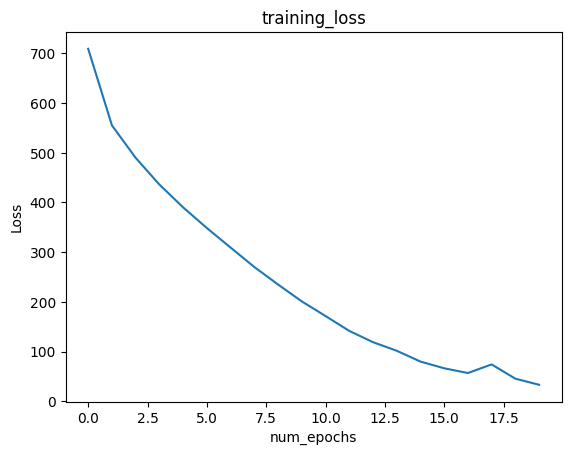

100%|██████████| 79/79 [00:18<00:00,  4.33it/s]


In [50]:
model_RELU = PatchConvNetAblation(num_classes=100, pretrained=False,drop_path_rate=drop_path_rate)
print("Z RELU")
train(model_RELU, train_loader, epochs=20,lr=lr,weight_decay=weight_decay)
acc1_RELU, acc5_RELU = evaluate(model_RELU, test_loader)

In [51]:
print("🔍 Porównanie:")
print(f"Oryginalny model  - Top1: {acc1_orig:.4f} | Top5: {acc5_orig:.4f}")
print(f"Model z RELU       - Top1: {acc1_RELU:.4f} | Top5: {acc5_RELU:.4f}")

🔍 Porównanie:
Oryginalny model  - Top1: 0.6504 | Top5: 0.9623
Model z RELU       - Top1: 0.6648 | Top5: 0.9629


Z RELU


100%|██████████| 391/391 [01:20<00:00,  4.86it/s]


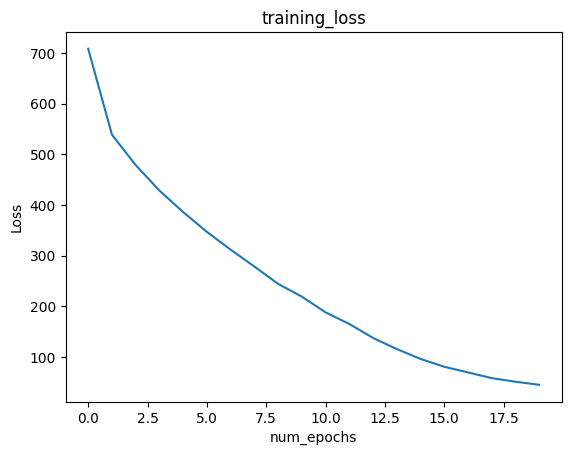

100%|██████████| 79/79 [00:17<00:00,  4.52it/s]


In [52]:
model_RELU = PatchConvNetAblation(num_classes=100, pretrained=False,drop_path_rate=drop_path_rate)
print("Z RELU")
train(model_RELU, train_loader, epochs=20,lr=lr,weight_decay=weight_decay)
acc1_RELU, acc5_RELU = evaluate(model_RELU, test_loader)

In [53]:
print("🔍 Porównanie:")
print(f"Oryginalny model  - Top1: {acc1_orig:.4f} | Top5: {acc5_orig:.4f}")
print(f"Model z RELU       - Top1: {acc1_RELU:.4f} | Top5: {acc5_RELU:.4f}")

🔍 Porównanie:
Oryginalny model  - Top1: 0.6504 | Top5: 0.9623
Model z RELU       - Top1: 0.6686 | Top5: 0.9649
